In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Embedding,Dense,Flatten,Concatenate
from tensorflow.keras.optimizers import SGD

## Data Preprocessing

In [2]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2020-04-22 10:06:12--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  17.5MB/s    in 12s     

2020-04-22 10:06:25 (15.5 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [3]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [4]:
!ls

ml-20m	ml-20m.zip  sample_data


In [5]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [0]:
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [0]:
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values

In [8]:
N = len(set(user_ids))
M = len(set(movie_ids))
print(f'Number of unique users: {N}')
print(f'Number of unique movies: {M}')

Number of unique users: 138493
Number of unique movies: 26744


## Model

In [0]:
K = 10 # Embedding dimension

u = Input(shape=(1,)) 
m = Input(shape=(1,))
u_emb = Embedding(N,K)(u) # output: (N,1,K)
m_emb = Embedding(M,K)(m) # output: (M,1,K)
u_emb = Flatten()(u_emb) # output: (N,K)
m_emb = Flatten()(m_emb) # output: (M,K)
x = Concatenate()([u_emb,m_emb]) # output: (num_of_samples,2K)
x = Dense(1024,activation='relu')(x)
x = Dense(1)(x)

model = Model(inputs=[u,m],outputs=x)

model.compile(loss='mse',optimizer=SGD(lr=0.01,momentum=0.9))

In [0]:
user_ids, movie_ids, ratings = shuffle(user_ids,movie_ids,ratings)
Ntrain = int(0.8*len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

In [0]:
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [12]:
model.fit(x=[train_user,train_movie],
          y=train_ratings,
          epochs=25,
          batch_size=1024,
          validation_data=([test_user,test_movie],test_ratings),
          verbose=2)

Epoch 1/25
15626/15626 - 65s - loss: 0.8585 - val_loss: 0.7763
Epoch 2/25
15626/15626 - 65s - loss: 0.7536 - val_loss: 0.7428
Epoch 3/25
15626/15626 - 65s - loss: 0.7310 - val_loss: 0.7283
Epoch 4/25
15626/15626 - 66s - loss: 0.7138 - val_loss: 0.7139
Epoch 5/25
15626/15626 - 66s - loss: 0.6992 - val_loss: 0.7031
Epoch 6/25
15626/15626 - 66s - loss: 0.6887 - val_loss: 0.6962
Epoch 7/25
15626/15626 - 65s - loss: 0.6817 - val_loss: 0.6929
Epoch 8/25
15626/15626 - 65s - loss: 0.6768 - val_loss: 0.6900
Epoch 9/25
15626/15626 - 65s - loss: 0.6728 - val_loss: 0.6863
Epoch 10/25
15626/15626 - 65s - loss: 0.6685 - val_loss: 0.6834
Epoch 11/25
15626/15626 - 64s - loss: 0.6640 - val_loss: 0.6805
Epoch 12/25
15626/15626 - 64s - loss: 0.6596 - val_loss: 0.6782
Epoch 13/25
15626/15626 - 65s - loss: 0.6556 - val_loss: 0.6756
Epoch 14/25
15626/15626 - 64s - loss: 0.6519 - val_loss: 0.6730
Epoch 15/25
15626/15626 - 64s - loss: 0.6487 - val_loss: 0.6722
Epoch 16/25
15626/15626 - 64s - loss: 0.6459 - va

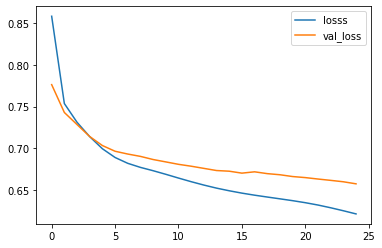

In [13]:
losses = pd.DataFrame(model.history.history)
plt.plot(losses['loss'],label='losss')
plt.plot(losses['val_loss'],label='val_loss')
plt.legend()
plt.show()